# Модель 3 (ResNet подобная + Vgg16 + SeparebleConv2D)

#### Импорт необходимых библиотек

In [1]:
import sys

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#### Аугментация (4)

In [2]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [3]:
train_ds, val_ds, test_ds = get_ds(
    'repaired_data_train', 'repaired_data_test',
    transform=transformer, one_hot=True, back=2
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [4]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

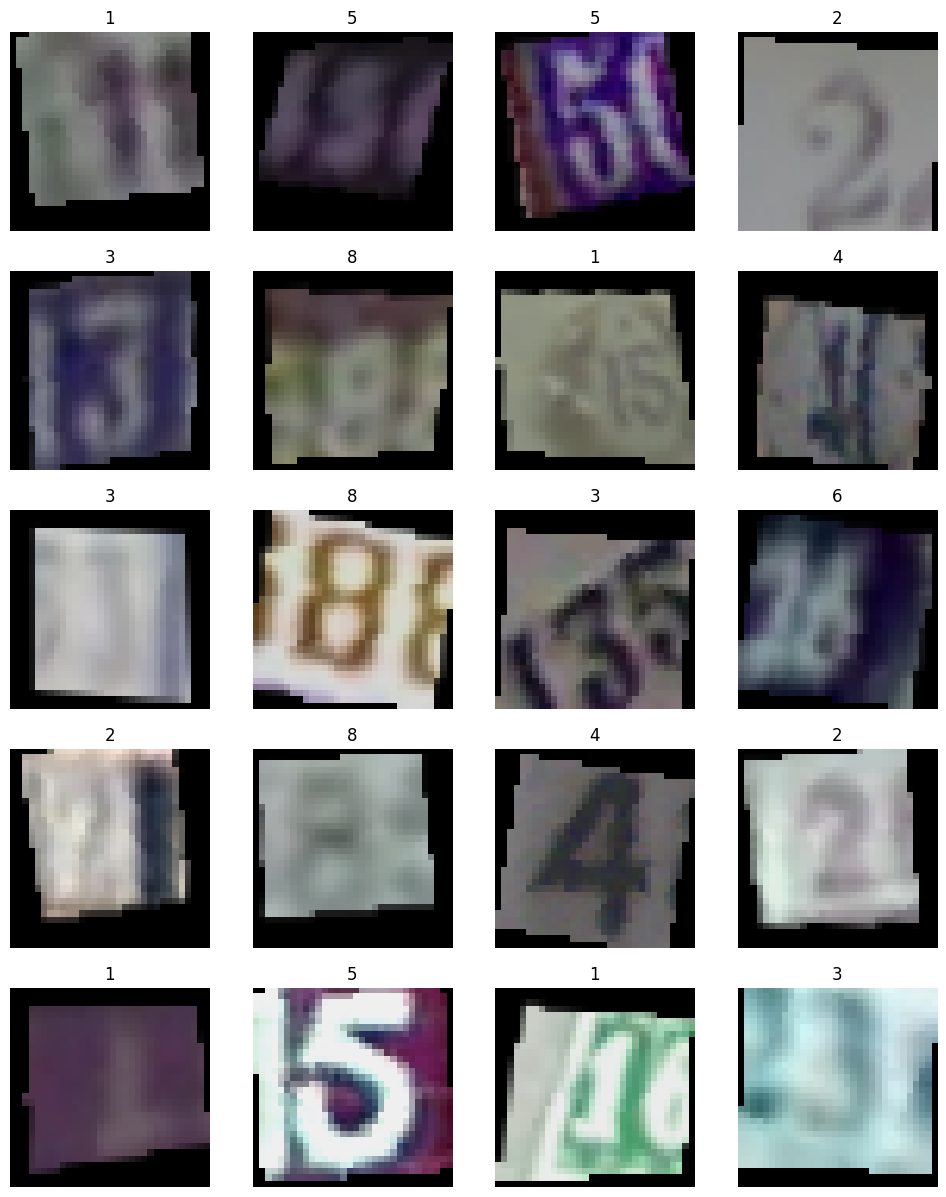

In [5]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель

Мысли о том, как я писал модель:
- В ResNet первая слой - большая свертка. (там (7, 7), для наших изображениц (5, 5))
- После большой свертки мы можем потерять фичи, поэтому skip-connectio между входным слоем и сверткой
- Как в Vgg-16 maxpooling, уменьшая размер, но увеличивая кол-во филтров и сверток в каждом блоке
- Делаем skip-connection между блоками как в resnet
- Как в ResNet заканчиваю GlobalMaxPool2D и Dense(10)

In [7]:
inputs = tf.keras.Input(shape=(32, 32, 3), batch_size=512)
block1 = tf.keras.layers.SeparableConv2D(32, (5, 5))(inputs)

x = tf.keras.layers.MaxPool2D(2)(block1)
x = tf.keras.layers.SeparableConv2D(64, (3, 3), padding='same')(x)
x = tf.keras.layers.SeparableConv2D(64, (3, 3), padding='same')(x)

block1_conv = tf.keras.layers.SeparableConv2D(64, (2, 2), strides=2)(block1)
block2 = tf.keras.layers.add([block1_conv, x])

x = tf.keras.layers.MaxPool2D(2)(block2)
x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same')(x)
x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same')(x)
x = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same')(x)

block2_conv = tf.keras.layers.SeparableConv2D(128, (2, 2), strides=2)(block2)
block3 = tf.keras.layers.add([block2_conv, x])

x = tf.keras.layers.MaxPool2D(2)(block3)
x = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same')(x)
x = tf.keras.layers.SeparableConv2D(256, (3, 3), padding='same')(x)
x = tf.keras.layers.SeparableConv2D(512, (2, 2), padding='same')(x)

block3_conv = tf.keras.layers.SeparableConv2D(512, (3, 3), strides=2)(block3)
block4 = tf.keras.layers.add([block3_conv, x])

x = tf.keras.layers.GlobalMaxPool2D()(block4)

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(512, 32, 32, 3)]   0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (512, 28, 28, 32)   203         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 max_pooling2d (MaxPooling2D)   (512, 14, 14, 32)    0           ['separable_conv2d[0][0]']       
                                                                                                  
 separable_conv2d_1 (SeparableC  (512, 14, 14, 64)   2400        ['max_pooling2d[0][0]']      

#### Создаем чекпоинты

In [5]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
num_model = '_g_3'
callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

#### Компиляция модели

In [9]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam()),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

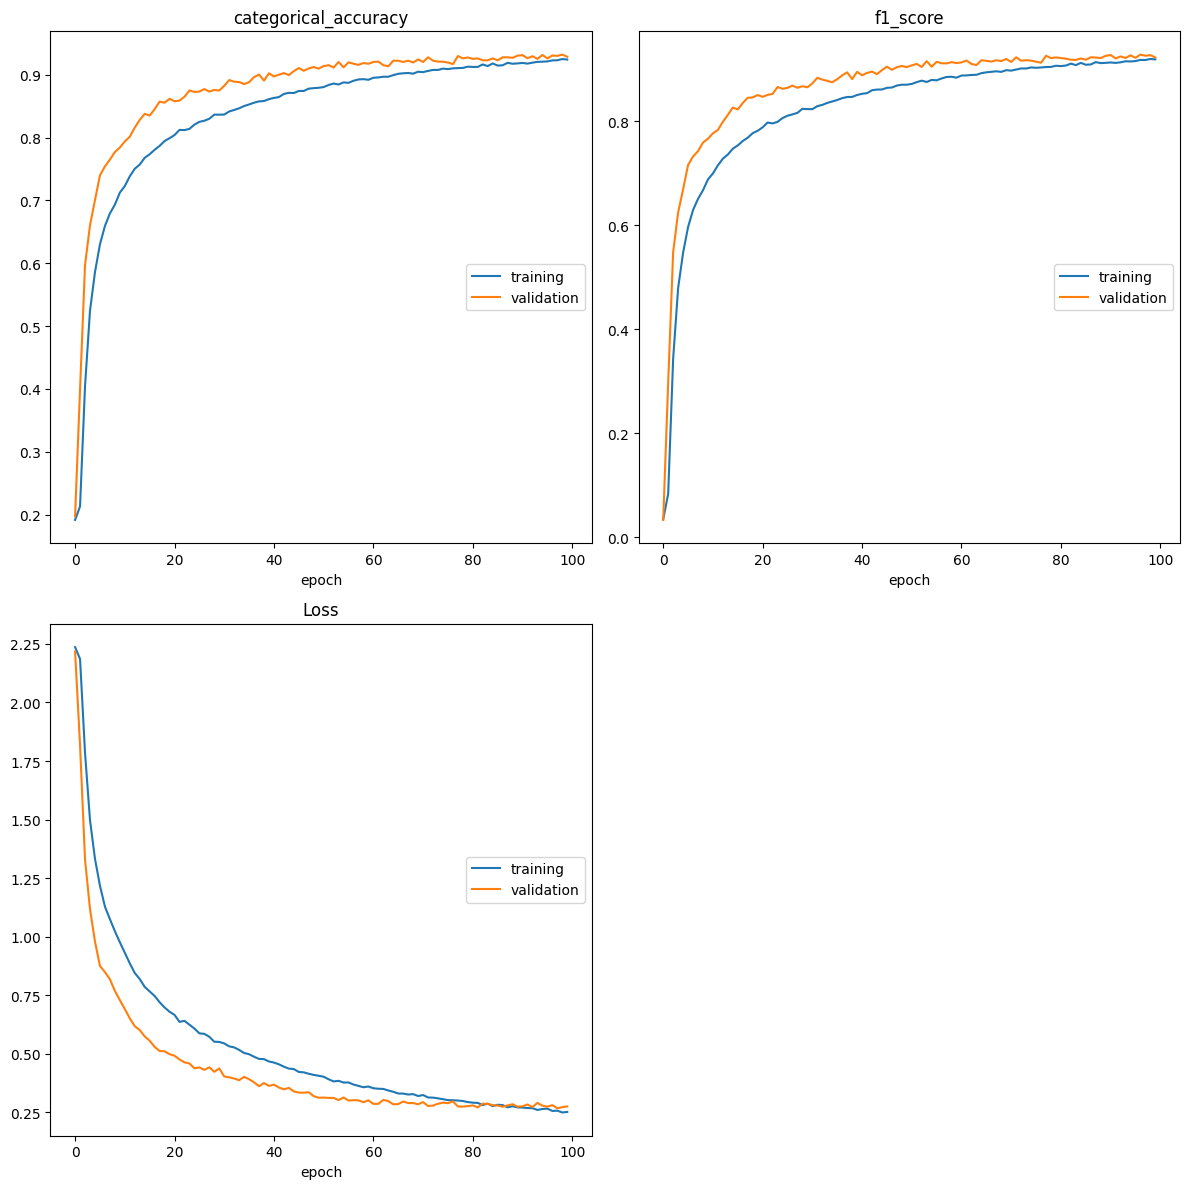

categorical_accuracy
	training         	 (min:    0.191, max:    0.925, cur:    0.924)
	validation       	 (min:    0.197, max:    0.932, cur:    0.929)
f1_score
	training         	 (min:    0.034, max:    0.919, cur:    0.919)
	validation       	 (min:    0.033, max:    0.928, cur:    0.922)
Loss
	training         	 (min:    0.249, max:    2.237, cur:    0.251)
	validation       	 (min:    0.266, max:    2.218, cur:    0.274)
91/91 [==============================] - 316s 3s/step - loss: 0.2507 - categorical_accuracy: 0.9241 - f1_score: 0.9187 - val_loss: 0.2744 - val_categorical_accuracy: 0.9286 - val_f1_score: 0.9223


In [10]:
model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

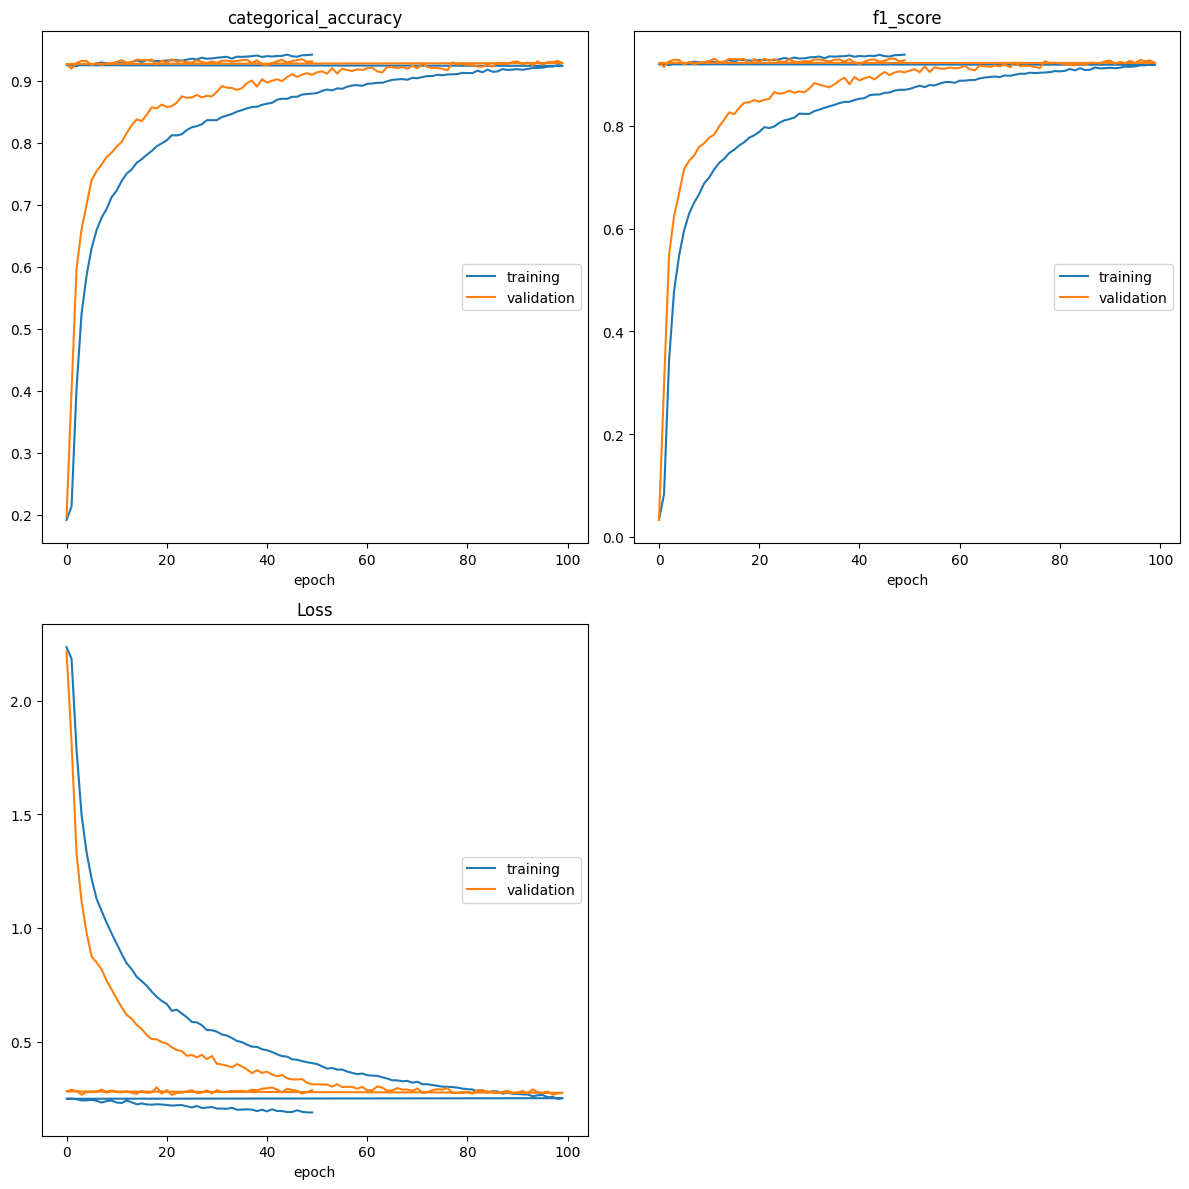

categorical_accuracy
	training         	 (min:    0.191, max:    0.942, cur:    0.942)
	validation       	 (min:    0.197, max:    0.935, cur:    0.931)
f1_score
	training         	 (min:    0.034, max:    0.938, cur:    0.938)
	validation       	 (min:    0.033, max:    0.931, cur:    0.927)
Loss
	training         	 (min:    0.188, max:    2.237, cur:    0.188)
	validation       	 (min:    0.265, max:    2.218, cur:    0.286)
91/91 [==============================] - 431s 5s/step - loss: 0.1879 - categorical_accuracy: 0.9423 - f1_score: 0.9385 - val_loss: 0.2858 - val_categorical_accuracy: 0.9314 - val_f1_score: 0.9275


In [11]:
model.fit(train_ds, validation_data=val_ds,
          epochs=50, callbacks=callbacks, verbose=1)

Переобучения нет, однако и улучшение в обучении отсуствует.

Подгружаем все чекпоинты

In [6]:
model_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_categorical_accuracy.h5')
model_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_f1_score.h5')
model_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_loss.h5')
model_avg_categorical_acc = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5')
model_avg_f1_score = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_f1_score.h5')
model_avg_loss = tf.keras.models.load_model(f'../checkpoints/model{num_model}_avg_loss.h5')

У нас поличилось шесть чекпоинта (шесть моделей). Ниже указан код для получения ответов для всех чекпоинтов по валидационному датасету.

In [7]:
ans_val_categorical_accuracy = make_ans_file(model_categorical_acc, val_ds_x)
ans_val_f1_score = make_ans_file(model_f1_score, val_ds_x)
ans_val_loss = make_ans_file(model_loss, val_ds_x)
ans_val_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, val_ds_x)
ans_val_avg_f1_score = make_ans_file(model_avg_f1_score, val_ds_x)
ans_val_avg_loss = make_ans_file(model_avg_loss, val_ds_x)
anss = [ans_val_categorical_accuracy, ans_val_f1_score, ans_val_loss, ans_val_avg_categorical_accuracy, ans_val_avg_f1_score, ans_val_avg_loss]

Формируем валидационные ответы.

In [8]:
val_ds_y = np.argmax(val_ds_y, axis=1)

Сравниваем валидационные предикты каждого чекпоинта

In [9]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

чекпоинты 1 и 3 одинаковые
чекпоинты 4 и 6 одинаковые


Рассмотрим только 1, 2, 4, 5

## ВЫВОД:

In [10]:
class MulticlassClassificationMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.matrix_error = self.get_matrix_error()

    def get_matrix_error(self):
        self.class_types = np.unique([self.y_true, self.y_pred])
        TP, FN, FP, TN = [], [], [], []
        for class_type in self.class_types:
            TP.append(np.sum(np.logical_and(self.y_true == self.y_pred, self.y_true == class_type)))
            FN.append(np.sum(np.logical_and(self.y_true == class_type, self.y_pred != class_type)))
            FP.append(np.sum(np.logical_and(self.y_pred == class_type, self.y_true != class_type)))
            TN.append(np.sum(np.logical_and(self.y_pred != class_type, self.y_true != class_type)))
        return pd.DataFrame({
            'class_type': self.class_types,
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        }).set_index('class_type')

    def accuracy(self):
        return np.sum(self.y_true == self.y_pred) / self.y_true.shape[0]

    def precision(self, averaging='macro'):
        if averaging == 'macro':
            precisions = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FP'])
            return np.mean(precisions.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FP'])

    def recall(self, averaging='macro'):
        if averaging == 'macro':
            recalls = self.matrix_error['TP'] / (self.matrix_error['TP'] + self.matrix_error['FN'])
            return np.mean(recalls.replace(np.nan, 0))
        elif averaging == 'micro':
            mean_val = self.matrix_error.mean()
            return mean_val['TP'] / (mean_val['TP'] + mean_val['FN'])

    def f1_score(self, averaging='macro'):
        if averaging == 'macro':
            reverse_r = (self.matrix_error['TP'] + self.matrix_error['FN']) / self.matrix_error['TP']
            reverse_p = (self.matrix_error['TP'] + self.matrix_error['FP']) / self.matrix_error['TP']
            f1_scores = 2 / (reverse_r + reverse_p)
            return np.mean(f1_scores.replace(np.nan, 0))
        elif averaging == 'micro':
            p = self.precision(averaging)
            r = self.recall(averaging)
            return 2 * p * r / (p + r)

    def metrics(self, averaging='macro'):
        return {
            'accuracy': self.accuracy(),
            'precision': self.precision(averaging),
            'recall': self.recall(averaging),
            'f1_score': self.f1_score(averaging),
        }

    def __str__(self):
        headers = {
            'selector': '*',
            'props': 'background-color: darkgreen; color: white; font-size: 12pt;',
        }
        che_super_mega_puper_visualization_of_cell = { 
            'selector': 'td:hover',
            'props': 'background-color: green; color: white;',
        }
        display(
            self.matrix_error
            .style
            .set_table_styles([
                headers,
                che_super_mega_puper_visualization_of_cell,
            ])
            .set_properties(**{'background-color': 'lightgreen',
                           'color': 'black', 'font-size': '12pt'})
        )
        return ''

    def __repr__(self):
        return (
            f'MulticlassClassificationMetrics(class_types={self.class_types})'
            .replace("'", '').replace(',', ';'))

### Accuracy чекпоинт

In [11]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,196,3292,5,8
1,684,2787,20,10
2,512,2965,11,13
3,379,3098,10,14
4,334,3154,6,7
5,332,3152,8,9
6,255,3233,10,3
7,260,3228,6,7
8,243,3245,5,8


{'accuracy': 0.9757212225078549,
 'precision': 0.9760568062823571,
 'recall': 0.974291959281499,
 'f1_score': 0.9751375004746308}

Можно заметить, что &FP_1&=20, модель не угадывает единицу

Метрики очень неплохие

## F1-score чекпоинт

In [15]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,200,3291,6,4
1,688,2785,22,6
2,516,2969,7,9
3,379,3104,4,14
4,333,3159,1,8
5,334,3143,17,7
6,251,3235,8,7
7,261,3229,5,6
8,242,3246,4,9


{'accuracy': 0.9780062839188803,
 'precision': 0.9785234524283173,
 'recall': 0.9758694815946184,
 'f1_score': 0.9771157667824536}

## Скользящее среднее по accuracy чекпоинт

In [16]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_categorical_accuracy)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,197,3291,6,7
1,681,2793,14,13
2,518,2963,13,7
3,381,3100,8,12
4,335,3157,3,6
5,331,3151,9,10
6,256,3233,10,2
7,258,3230,4,9
8,244,3246,4,7


{'accuracy': 0.9785775492716366,
 'precision': 0.9783448033352957,
 'recall': 0.9778006958389043,
 'f1_score': 0.9780273332872176}

### Скользящее среднее по F1-score чекпоинт.

In [17]:
metrics = MulticlassClassificationMetrics(val_ds_y, ans_val_avg_f1_score)
print(metrics)
metrics.metrics()

,TP,TN,FP,FN
class_type,,,,
0,198,3294,3,6
1,688,2795,12,6
2,520,2971,5,5
3,382,3104,4,11
4,337,3158,2,4
5,334,3150,10,7
6,255,3238,5,3
7,262,3230,4,5
8,247,3246,4,4


{'accuracy': 0.9848614681519566,
 'precision': 0.984540392633777,
 'recall': 0.983706967982567,
 'f1_score': 0.9841021264183724}

Можно заметить, что модель очень плохо угадывает 1

(array([204., 694., 525., 393., 341., 341., 258., 267., 251., 227.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

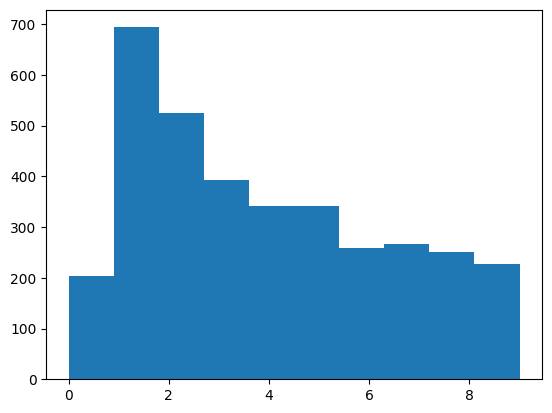

In [24]:
plt.hist(val_ds_y)

Как видно кол-во 1 очень мало. Поэтому я и миша разбираемся с этим вопросом. 

- Сохраняем ответы.

In [18]:
ans_test_categorical_accuracy = make_ans_file(model_categorical_acc, test_ds, f'../answers/model{num_model}_categorical_accuracy.csv')
ans_test_f1_score = make_ans_file(model_f1_score, test_ds, f'../answers/model{num_model}_f1_score.csv')
ans_test_loss = make_ans_file(model_loss, test_ds, f'../answers/model{num_model}_loss.csv')
ans_test_avg_categorical_accuracy = make_ans_file(model_avg_categorical_acc, test_ds, f'../answers/model{num_model}_avg_categorical_accuracy.csv')
ans_test_avg_f1_score = make_ans_file(model_avg_f1_score, test_ds, f'../answers/model{num_model}_avg_f1_score.csv')
ans_test_avg_loss = make_ans_file(model_avg_loss, test_ds, f'../answers/model{num_model}_avg_loss.csv')
anss = [ans_test_categorical_accuracy, ans_test_f1_score, ans_test_avg_categorical_accuracy, ans_test_avg_f1_score]

Проверяем ответы (одинаковые они или нет), чтоб не терять кол-во отправок ответов на kaggle в день.

In [23]:
for i in range(len(anss) - 1):
    for j in range(i + 1, len(anss)):
        if np.all(anss[i] == anss[j]):
            print(f'чекпоинты {i + 1} и {j + 1} одинаковые')

Все ответы разные, поэтому отправляем все на kaggle `categorical_accuracy`, `f1_score`, `avg_categorical_accuracy`, `avg_f1_score` чекпоинты